In [1]:
# import dependencies
import nltk
import pandas as pd
import os
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib notebook
from nltk import tokenize
import string
import re

In [2]:
# load tweets into a dataframe
df18 = pd.read_json(os.path.join('condensed_2018.json'))
df17 = pd.read_json(os.path.join('condensed_2017.json'))
frames = [df18, df17]
result = pd.concat(frames)
# Reset index
result = result.reset_index(drop=True)
# drop retweets
dfRt = result[~result.text.str.startswith('RT')]
# Reset index
dfRt = dfRt.reset_index(drop=True)

In [3]:
# create day of the week column for plotting
# next steps: make columns for hour, month, year for additional plots
dfRt['created_at'] = pd.to_datetime(dfRt['created_at'])

dfRt['day_of_week'] = dfRt['created_at'].dt.day_name()

In [4]:
# ser variable for seniment analyzer
sid = SentimentIntensityAnalyzer()

# set text column to a varible for vader analysis
sentences = dfRt["text"]

# create list for polarity scores
vScore = []

# run vader on text
for sentence in sentences:
    ss = sid.polarity_scores(sentence)

# append score to list
    vScore.append((ss.get("compound")))

# add list to dataframe for plotting
dfRt["vScore"]= pd.DataFrame(vScore)

In [5]:
classed = []

# For each row in the column,
for row in dfRt['vScore']:
    # if more than a value,
    if row > 0:
        # Append a letter grade
        classed.append('Positive')
    else:
        # Append a failing grade
        classed.append('Negative')
        
# Create a column from the list
dfRt['classed'] = classed

In [6]:
dfRt.head()

,source,id_str,text,created_at,retweet_count,in_reply_to_user_id_str,favorite_count,is_retweet,day_of_week,vScore,classed
0,Twitter for iPhone,1079888205351145472,HAPPY NEW YEAR! https://t.co/bHoPDPQ7G6,2018-12-31 23:53:06+00:00,33548,NaN,136012,False,Monday,0.6932,Positive
1,Twitter for iPhone,1079830268708556800,"....Senator Schumer, more than a year longer t...",2018-12-31 20:02:52+00:00,17456,25073877.0,65069,False,Monday,-0.2908,Negative
2,Twitter for iPhone,1079830267274108928,Heads of countries are calling wanting to know...,2018-12-31 20:02:52+00:00,21030,NaN,76721,False,Monday,0.8652,Positive
3,Twitter for iPhone,1079763923845419008,It’s incredible how Democrats can all use thei...,2018-12-31 15:39:15+00:00,29610,NaN,127485,False,Monday,-0.8843,Negative
4,Twitter for iPhone,1079763419908243456,"I’m in the Oval Office. Democrats, come back f...",2018-12-31 15:37:14+00:00,30957,NaN,132439,False,Monday,0.5707,Positive


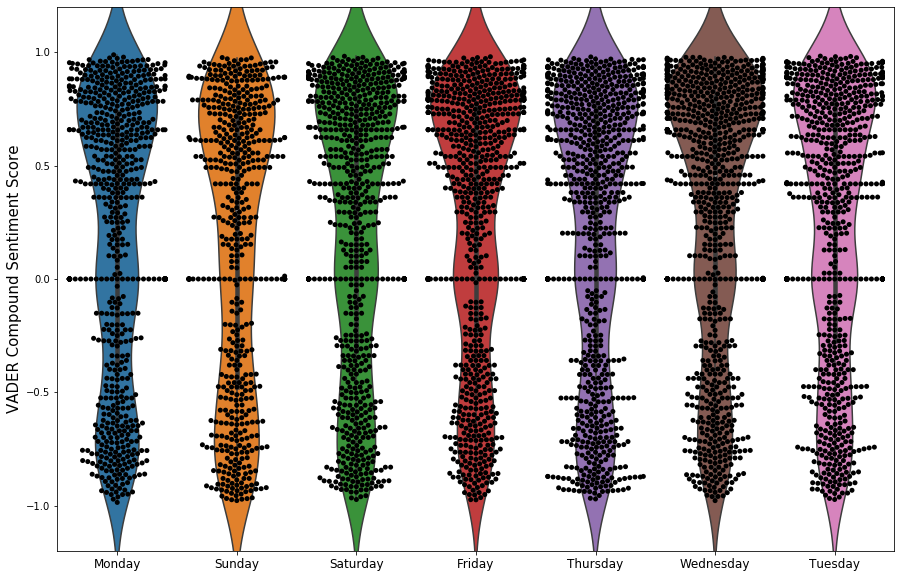

In [7]:
# plot sentiment of tweets according to day of the week
plt.close()
plt.figure(figsize=(15,10))
plt.ylim(-1.2,1.2)
sns.violinplot(x='day_of_week',y='vScore',data=dfRt)
sns.swarmplot(x="day_of_week", y="vScore",data=dfRt, color="black")
plt.xlabel('')
plt.xticks(size=12)
plt.ylabel('VADER Compound Sentiment Score',size=15)
plt.savefig('sentiment.png')


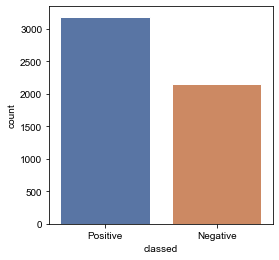

In [8]:
fig, ax = plt.subplots(figsize=(4,4 ))
sns.set(style="whitegrid")
ax = sns.countplot(x="classed", data=dfRt)

In [9]:

### sklearn
from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix, accuracy_score

### numpy for seed.  Good practice for reproducibility, not something we touched on but worth wild to look further.
import numpy as np
from numpy import random

SEED = 1234

random.seed(SEED)

In [10]:
translator = str.maketrans('', '', string.punctuation)
tk = tokenize.simple.SpaceTokenizer()

def simple_tokenizer(x):
    x = x.translate(translator).strip().lower()
    return tk.tokenize(x)

### Quick look at what the tokenizer produces
print(dfRt['text'].head().apply(lambda x : simple_tokenizer(x)))

### Developing the corpus or list of sentences for processing later
corpus = dfRt['text'].tolist()
corpus[0:5]

0               [happy, new, year, httpstcobhopdpq7g6]
1    [senator, schumer, more, than, a, year, longer...
2    [heads, of, countries, are, calling, wanting, ...
3    [it’s, incredible, how, democrats, can, all, u...
4    [i’m, in, the, oval, office, democrats, come, ...
Name: text, dtype: object


['HAPPY NEW YEAR! https://t.co/bHoPDPQ7G6',
 '....Senator Schumer, more than a year longer than any other Administration in history. These are people who have been approved by committees and all others, yet Schumer continues to hold them back from serving their Country! Very Unfair!',
 'Heads of countries are calling wanting to know why Senator Schumer is not approving their otherwise approved Ambassadors!? Likewise in Government lawyers and others are being delayed at a record pace! 360 great and hardworking people are waiting for approval from....',
 'It’s incredible how Democrats can all use their ridiculous sound bite and say that a Wall doesn’t work. It does, and properly built, almost 100%! They say it’s old technology - but so is the wheel. They now say it is immoral- but it is far more immoral for people to be dying!',
 'I’m in the Oval Office. Democrats, come back from vacation now and give us the votes necessary for Border Security, including the Wall. You voted yes in 2006 a

In [11]:
vectorizer = TfidfVectorizer(tokenizer=simple_tokenizer, stop_words='english')
tf = vectorizer.fit(corpus)
X = tf.transform(corpus)

### Combining result of TFIDF with `target` columns
full_df = pd.concat([pd.DataFrame(X.toarray()), dfRt['vScore']], axis=1)
print("Vector features : ", vectorizer.get_feature_names()[0:20])
print("Vector shape/size : ",X.shape)

Vector features :  ['', '\n', '\n\nfirst', '\n\ngod', '\n\nhappy', '\n\nhttpstcojbn4hpjqjs', '\n\ni', '\n\nicegov', '\n\nnow', '\n\nthank', '\n\nwatch➡️httpstcoimizr22gaw', '\n\nwe', '\n\n“trump’s', '\n18003423557\nhttpstcozbwkr5vmdp\n\nvolunteer', '\n1800flhelp1\nhttpstcoghkbvajbn0', '\nadministrator', '\narmynavygame', '\nchris', '\ndow23k', '\ndown📉315']
Vector shape/size :  (5341, 12137)


In [12]:
from sklearn.model_selection import train_test_split
y = dfRt['vScore']
X_train, X_test, y_train, y_test = train_test_split (X, y, test_size=0.2)


print (X_train.shape, y_train.shape)

(4272, 12137) (4272,)


In [13]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues,
                          include_cm=False,
                          fig_size=(10, 8)):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    from sklearn.utils.multiclass import unique_labels
    
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    if include_cm:
        print(cm)

    fig, ax = plt.subplots(figsize=fig_size)
    ax.grid(False)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [14]:
y_train = y_train.astype('int')

In [15]:
y_train.shape

(4272,)

In [16]:
clf = MultinomialNB().fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [17]:
confusion_matrix(y_test, y_pred)

ValueError: Classification metrics can't handle a mix of continuous and binary targets

In [ ]:
y_test

In [ ]:
y_pred